# Image Matting

In [0]:
# import numpy as np
# import pandas as pd 
# 
# import cv2
# from sklearn.metrics import f1_score

# import tensorflow as tf
# %matplotlib inline



Original Image

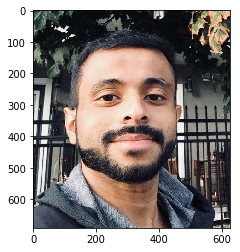

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('image.png')
imgplot = plt.imshow(img)
plt.show()

# Using Scribbles

### We create our scribbles and it looks like below

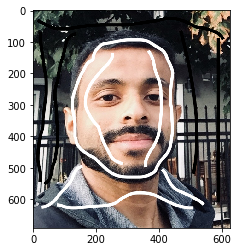

In [4]:
trimap = mpimg.imread('scribbles.png')
imgplot = plt.imshow(trimap)
plt.show()

In [5]:
trimap.shape

(691, 625, 4)

So scribbles are basically outlines to seperate our foreground from the background

### The trimap has to be of same shape as the input image except the 3 channels

In [0]:
import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg
import logging


def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)


def compute_laplacian(img, mask=None, eps=10**(-7), win_rad=1):
    """Computes Matting Laplacian for a given image.
    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(np.bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))

    X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
    return L


def closed_form_matting_with_prior(image, prior, prior_confidence, consts_map=None):
    """Applies closed form matting with prior alpha map to image.
    Args:
        image: 3-dim numpy matrix with input image.
        prior: matrix of same width and height as input image holding apriori alpha map.
        prior_confidence: matrix of the same shape as prior hodling confidence of prior alpha.
        consts_map: binary mask of pixels that aren't expected to change due to high
            prior confidence.
    Returns: 2-dim matrix holding computed alpha map.
    """

    assert image.shape[:2] == prior.shape, ('prior must be 2D matrix with height and width equal '
                                            'to image.')
    assert image.shape[:2] == prior_confidence.shape, ('prior_confidence must be 2D matrix with '
                                                       'height and width equal to image.')
    assert (consts_map is None) or image.shape[:2] == consts_map.shape, (
        'consts_map must be 2D matrix with height and width equal to image.')

    logging.info('Computing Matting Laplacian.')
    laplacian = compute_laplacian(image, ~consts_map if consts_map is not None else None)

    confidence = scipy.sparse.diags(prior_confidence.ravel())
    logging.info('Solving for alpha.')
    solution = scipy.sparse.linalg.spsolve(
        laplacian + confidence,
        prior.ravel() * prior_confidence.ravel()
    )
    alpha = np.minimum(np.maximum(solution.reshape(prior.shape), 0), 1)
    return alpha
  
def closed_form_matting_with_trimap(image, trimap, trimap_confidence=100.0):
    """Apply Closed-Form matting to given image using trimap."""

    assert image.shape[:2] == trimap.shape, ('trimap must be 2D matrix with height and width equal '
                                             'to image.')
    consts_map = (trimap < 0.1) | (trimap > 0.9)
    return closed_form_matting_with_prior(image, trimap, trimap_confidence * consts_map, consts_map)



def closed_form_matting_with_scribbles(image, scribbles, scribbles_confidence=100.0):
    """Apply Closed-Form matting to given image using scribbles image."""

    assert image.shape == scribbles.shape, 'scribbles must have exactly same shape as image.'
    prior = np.sign(np.sum(scribbles - image, axis=2)) / 2 + 0.5
    consts_map = prior != 0.5
    return closed_form_matting_with_prior(
        image,
        prior,
        scribbles_confidence * consts_map,
        consts_map
    )




In [0]:
image = cv2.imread("image.png", cv2.IMREAD_COLOR) / 255.0

In [0]:
scribbles = cv2.imread("scribbles.png", cv2.IMREAD_COLOR) / 255.0

In [0]:
alpha = closed_form_matting_with_scribbles(image, scribbles)

In [0]:
output = alpha

In [11]:
cv2.imwrite("output_alpha.png", output * 255.0)

True

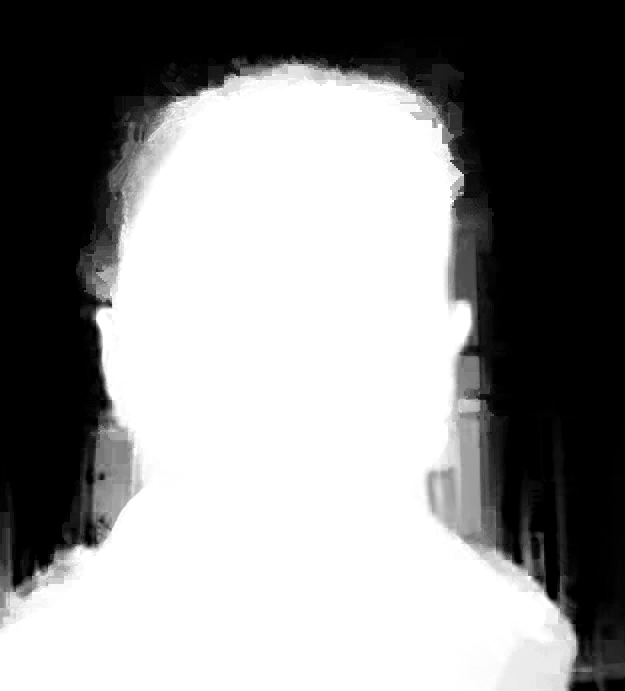

In [12]:
from google.colab.patches import cv2_imshow #only for google colab in case of Jupyter use cv2.imshow
cv2_imshow(cv2.imread("output_alpha.png", cv2.IMREAD_COLOR))

In [0]:
CONST_ALPHA_MARGIN = 0.02


def __spdiagonal(diag):
    """Produces sparse matrix with given vector on its main diagonal."""
    return scipy.sparse.spdiags(diag, (0,), len(diag), len(diag))


def get_grad_operator(mask):
    """Returns sparse matrix computing horizontal, vertical, and two diagonal gradients."""
    horizontal_left = np.ravel_multi_index(np.nonzero(mask[:, :-1] | mask[:, 1:]), mask.shape)
    horizontal_right = horizontal_left + 1

    vertical_top = np.ravel_multi_index(np.nonzero(mask[:-1, :] | mask[1:, :]), mask.shape)
    vertical_bottom = vertical_top + mask.shape[1]

    diag_main_1 = np.ravel_multi_index(np.nonzero(mask[:-1, :-1] | mask[1:, 1:]), mask.shape)
    diag_main_2 = diag_main_1 + mask.shape[1] + 1

    diag_sub_1 = np.ravel_multi_index(np.nonzero(mask[:-1, 1:] | mask[1:, :-1]), mask.shape) + 1
    diag_sub_2 = diag_sub_1 + mask.shape[1] - 1

    indices = np.stack((
        np.concatenate((horizontal_left, vertical_top, diag_main_1, diag_sub_1)),
        np.concatenate((horizontal_right, vertical_bottom, diag_main_2, diag_sub_2))
    ), axis=-1)
    return scipy.sparse.coo_matrix(
        (np.tile([-1, 1], len(indices)), (np.arange(indices.size) // 2, indices.flatten())),
        shape=(len(indices), mask.size))


def get_const_conditions(image, alpha):
    """Returns sparse diagonal matrix and vector encoding color prior conditions."""
    falpha = alpha.flatten()
    weights = (
        (falpha < CONST_ALPHA_MARGIN) * 100.0 +
        0.03 * (1.0 - falpha) * (falpha < 0.3) +
        0.01 * (falpha > 1.0 - CONST_ALPHA_MARGIN)
    )
    conditions = __spdiagonal(weights)

    mask = falpha < 1.0 - CONST_ALPHA_MARGIN
    right_hand = (weights * mask)[:, np.newaxis] * image.reshape((alpha.size, -1))
    return conditions, right_hand


def solve_foreground_background(image, alpha):
    """Compute foreground and background image given source image and transparency map."""

    consts = (alpha < CONST_ALPHA_MARGIN) | (alpha > 1.0 - CONST_ALPHA_MARGIN)
    grad = get_grad_operator(~consts)
    grad_weights = np.power(np.abs(grad * alpha.flatten()), 0.5)

    grad_only_positive = grad.maximum(0)
    grad_weights_f = grad_weights + 0.003 * grad_only_positive * (1.0 - alpha.flatten())
    grad_weights_b = grad_weights + 0.003 * grad_only_positive * alpha.flatten()

    grad_pad = scipy.sparse.coo_matrix(grad.shape)

    smoothness_conditions = scipy.sparse.vstack((
        scipy.sparse.hstack((__spdiagonal(grad_weights_f) * grad, grad_pad)),
        scipy.sparse.hstack((grad_pad, __spdiagonal(grad_weights_b) * grad))
    ))

    composite_conditions = scipy.sparse.hstack((
        __spdiagonal(alpha.flatten()),
        __spdiagonal(1.0 - alpha.flatten())
    ))

    const_conditions_f, b_const_f = get_const_conditions(image, 1.0 - alpha)
    const_conditions_b, b_const_b = get_const_conditions(image, alpha)

    non_zero_conditions = scipy.sparse.vstack((
        composite_conditions,
        scipy.sparse.hstack((
            const_conditions_f,
            scipy.sparse.coo_matrix(const_conditions_f.shape)
        )),
        scipy.sparse.hstack((
            scipy.sparse.coo_matrix(const_conditions_b.shape),
            const_conditions_b
        ))
    ))

    b_composite = image.reshape(alpha.size, -1)

    right_hand = non_zero_conditions.transpose() * np.concatenate((b_composite,
                                                                   b_const_f,
                                                                   b_const_b))

    conditons = scipy.sparse.vstack((
        non_zero_conditions,
        smoothness_conditions
    ))
    left_hand = conditons.transpose() * conditons

    solution = scipy.sparse.linalg.spsolve(left_hand, right_hand).reshape(2, *image.shape)
    foreground = solution[0, :, :, :].reshape(*image.shape)
    background = solution[1, :, :, :].reshape(*image.shape)
    return foreground, background

In [0]:
foreground, _ = solve_foreground_background(image, alpha)
output = np.concatenate((foreground, alpha[:, :, np.newaxis]), axis=2)

In [15]:
cv2.imwrite("output.png", output * 255.0)

True

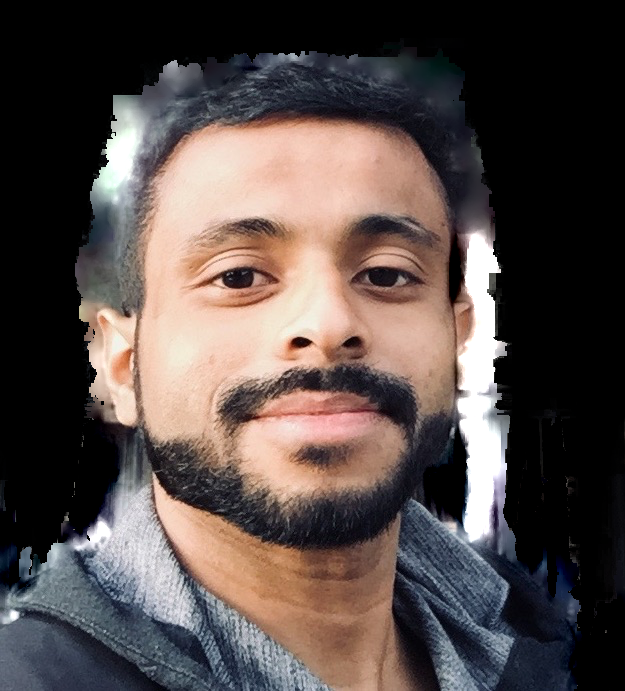

In [16]:
cv2_imshow(cv2.imread("output.png", cv2.IMREAD_COLOR))

# Using Trimap

In [0]:
trimap = np.zeros((691,625))+175.0

In [32]:
cv2.imwrite("trimap.png",trimap)

True

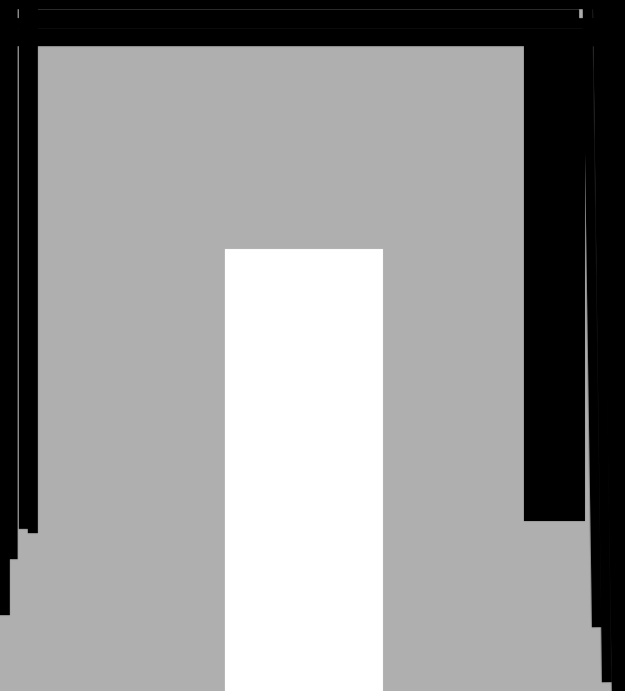

In [36]:
cv2_imshow(cv2.imread("trimap.png", cv2.IMREAD_COLOR))

In [0]:
image = cv2.imread("image.png", cv2.IMREAD_COLOR) / 255.0

In [0]:
trimap = cv2.imread("trimap.png", cv2.IMREAD_GRAYSCALE) / 255.0

In [0]:
alpha = closed_form_matting_with_trimap(image, trimap)

In [0]:
foreground, _ = solve_foreground_background(image, alpha)
output = np.concatenate((foreground, alpha[:, :, np.newaxis]), axis=2)

In [41]:
cv2.imwrite("output_trimap.png", output * 255.0)

True

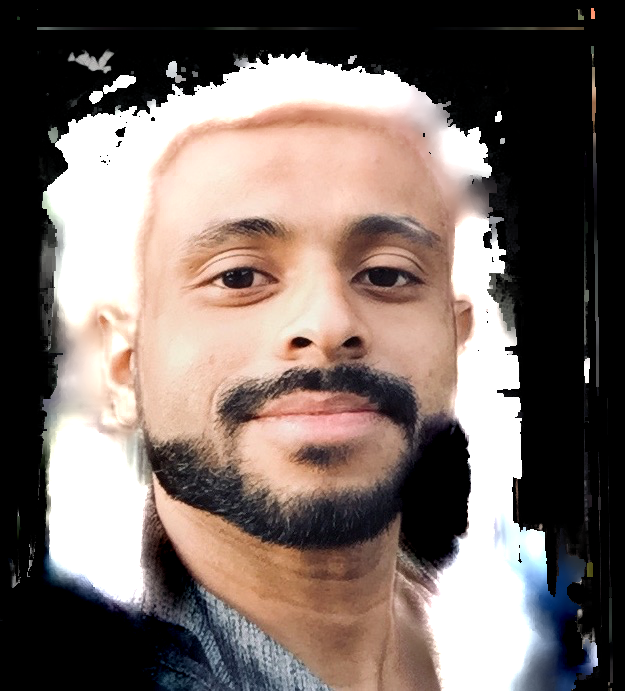

In [42]:
cv2_imshow(cv2.imread("output_trimap.png", cv2.IMREAD_COLOR))